In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn import linear_model
from sklearn.metrics import r2_score, root_mean_squared_error

## Trying to improve results

#### Taking means from multiple spectroscopy runs

Each csv file holds current and distance away from sample and tip ($Z$). Each voltage measurement is the same between CSV file so the important data to take means from is current.
Each current column was saved in a big data frame and once all current values were processed, the mean was calculated and stored.

In [2]:
#Initialising each variable
file_prefix = "I-Z spectroscopy"
materials = ["graphite", "gold", "silicon"]

#dictionary to hold material, mean current data frame pairs
mean_dfs = {}

#iterating over each material
for material in materials:
    #setting up data frame to hold each current value
    volt_column = False
    grand_df = pd.DataFrame({})

    #looping over 16 csv w/ the naming convention
    for i in range(1, 13):
        if material == "silicon" and i > 10:
            break
        else:
            #storing raw spectroscopy data in data frame
            spectroscopy = pd.read_csv(f"Worthwhile Scans\\week 6\\{material} I-Z csvs\\{file_prefix} {i}.csv",
                                   names=["Z (m)", "Current (A)"],
                                   sep=";")
    
            #if statement set up to only write voltage column once
            if volt_column == False:
                grand_df["Z (m)"] = spectroscopy["Z (m)"]
                volt_column = True
    
            #Writing current to big data frame
            grand_df[f"Current (A) {i}"] = spectroscopy["Current (A)"]
    
            #calculate mean current of all 12 current
            mean_df = pd.DataFrame({"Z (m)":grand_df["Z (m)"],
                               "Mean Current (A)":grand_df.iloc[:, 1:].mean(axis=1)})
            mean_df.to_csv(f"I-Z mean spectroscopy {material}.csv", index=False)
    
            #write data frame of voltage and current to dictionary
            mean_dfs[material] = mean_df


#### Keeping only Exponential and not when Tip Contacts Surface

1. **Initialize and Copy Data**:
   - `mean_dfs_trunc` is created as a copy of `mean_dfs`, ensuring that we have a separate DataFrame collection to store truncated data for each material without modifying the original.

2. **Plotting the Full Data**:
   - For each material:
     - A figure (`fig`) and axis (`ax`) are created with a size of 4x3 inches to visualize the full current data.
     - The `plot()` function is used to plot "Mean Current (A)" against "Z (m)", with the `label` parameter set to the material's name.
     - The title "I-Z Exponential Curves (raw data)" is added to indicate that this plot represents the entire data set.

3. **Identifying the Peak and Truncating the Data**:
   - The index of the maximum current value for each material is found using `np.argmax()`, which identifies where the "Mean Current (A)" reaches its peak.
   - Using this index, the data is truncated in `mean_dfs_trunc[material]` to include only the values up to this peak. This removes any points beyond the peak, which may correspond to irrelevant or post-peak data.

4. **Plotting the Truncated Data**:
   - A second figure (`fig`) and axis (`ax2`) are created with a larger size of 8x4 inches for clarity in observing the truncated data.
   - The truncated dataset is then plotted on `ax2`, again showing "Mean Current (A)" against "Z (m)" with the material name as the label.
   - The title "I-Z Exponential Curves (Truncated)" is added to indicate this plot represents data up to the maximum current point.

5. **Axis Labels and Legend**:
   - Labels for the x-axis ("Z (m)") and y-axis ("Mean Current (A)") are added to the first axis (`ax`) to ensure consistent labeling across materials.
   - Finally, a legend is created to identify each material's data on the plots.

This code provides two plots per material: one for the full data and another for the truncated data up to the current peak. These visualizations aid in analyzing the exponential trend in "Mean Current (A)" while filtering out irrelevant post-peak data.

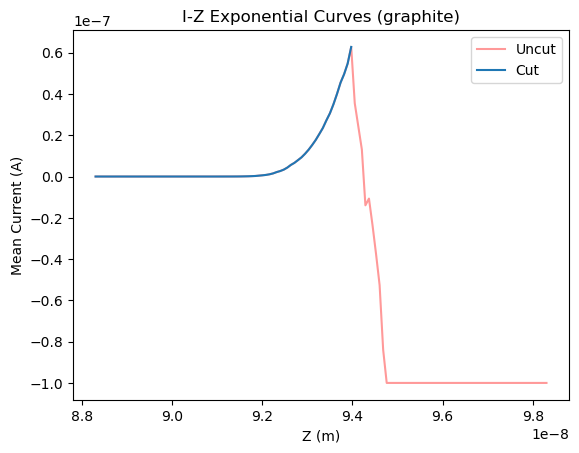

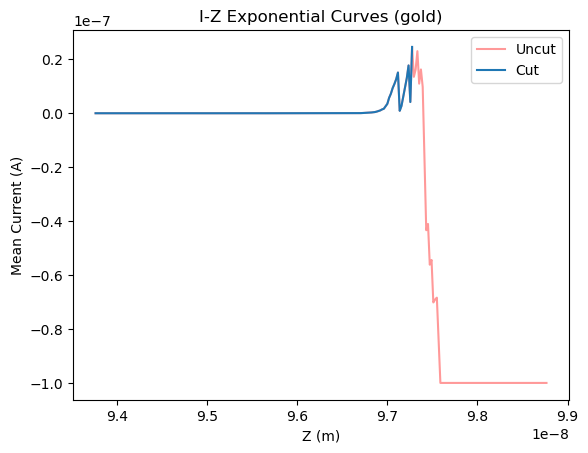

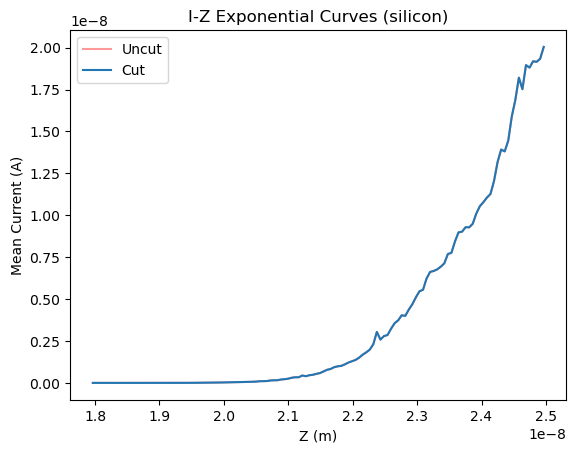

In [3]:
mean_dfs_trunc = mean_dfs.copy()
for material in materials:
    fig, ax = plt.subplots()
    mean_dfs[material].plot("Z (m)", "Mean Current (A)", ax = ax, label = "Uncut", color = "red", alpha = 0.4)
    max_index = np.argmax(mean_dfs[material]["Mean Current (A)"])
    
    mean_dfs_trunc[material] = mean_dfs[material][:max_index+1]
    mean_dfs_trunc[material].plot("Z (m)", "Mean Current (A)", ax = ax, label = "Cut")
    ax.set_title(f"I-Z Exponential Curves ({material})")
    ax.set_xlabel("Z (m)")
    ax.set_ylabel("Mean Current (A)")

plt.legend()

#### How to Dynamically Determine When the Exponential Starts

1. **Setup and Parameters**:
   - For each material, we extract the corresponding data from `mean_dfs_trunc`, a dictionary that stores DataFrames, where each DataFrame contains the "Mean Current (A)" column.
   - We initialize the following parameters:
     - `initial_window` (set to 5): Starting size for our moving window to calculate variance.
     - `max_window` (set to 50): Maximum allowed window size to limit computational expense.
     - `change_threshold` (set to 50%): Percentage change in variance required to identify the beginning of exponential growth.

2. **Dynamic Window Size Calculation**:
   - We initialize `window_size` with `initial_window` and calculate the initial variance over the first `window_size` data points.
   - A `while` loop then gradually increases the `window_size` until one of two conditions is met:
     - The window size reaches `max_window`.
     - The percentage change in variance between the current and previous windows exceeds the `change_threshold`.
   - If the variance change surpasses `change_threshold`, it suggests increased fluctuation, potentially signaling the start of exponential growth. The loop stops, and the dynamically adjusted `window_size` is used for further calculations.

3. **Rolling Mean and Standard Deviation Calculation**:
   - Using the determined `window_size`, we compute a rolling mean and rolling standard deviation for the "Mean Current (A)" column. This helps smooth out the data, making it easier to detect significant deviations.

4. **Threshold Definition**:
   - We set a threshold to identify exponential growth, calculated as:


     $\text{threshold} = \text{rolling mean} + 4.75 \times \text{rolling standard deviation}$

   - This threshold is higher than the rolling mean, accounting for normal fluctuations while flagging significant deviations.

5. **Finding the Start of Exponential Growth**:
   - Finally, the code identifies the first index where the current data exceeds this threshold, indicating the point at which exponential growth likely begins. This index is printed for each material.

Each material's dynamic window size and the index at which exponential growth starts are printed to help identify trends and changes in the "Mean Current (A)" data.

graphite
Dynamically determined window size: 38
Index of the start of exponential growth: 42


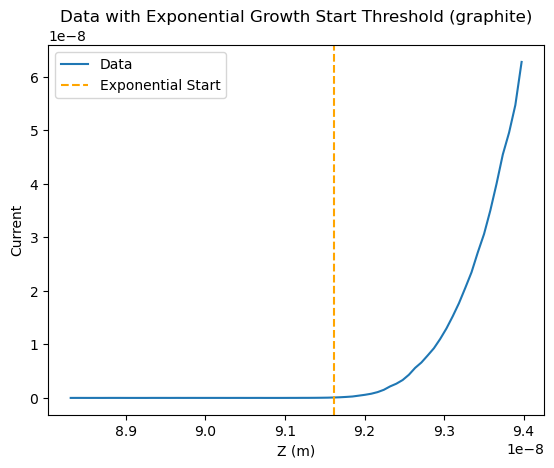

gold
Dynamically determined window size: 50
Index of the start of exponential growth: 149


C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lj22452\AppData\Local\Temp\ipykernel_15516\514442326.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_dfs_trunc[material]["ln(Mean Current (A))"] = np.log(mean_dfs_trunc[material]["Mean Current (A)"])


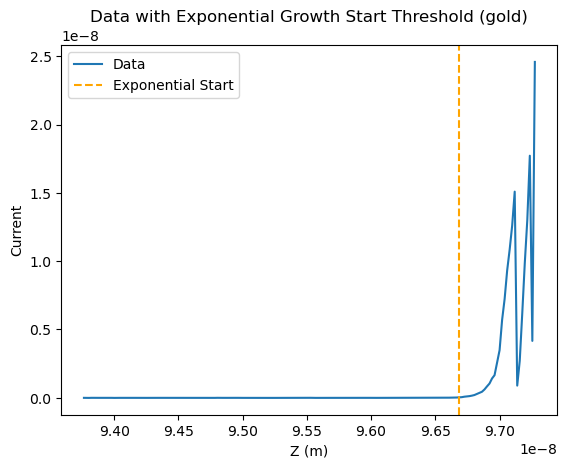

silicon
Dynamically determined window size: 14
Index of the start of exponential growth: 0


C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lj22452\AppData\Local\Temp\ipykernel_15516\514442326.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_dfs_trunc[material]["ln(Mean Current (A))"] = np.log(mean_dfs_trunc[material]["Mean Current (A)"])


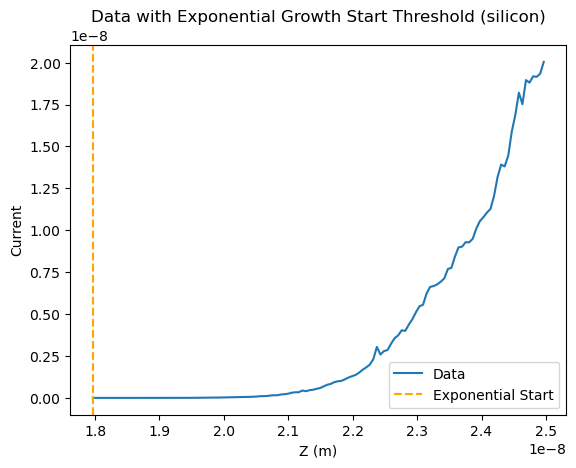

C:\Users\lj22452\AppData\Local\Temp\ipykernel_15516\514442326.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_dfs_trunc[material]["ln(Mean Current (A))"] = np.log(mean_dfs_trunc[material]["Mean Current (A)"])


In [4]:
for i, material in enumerate(materials):
    df = mean_dfs_trunc[material]
    print(material)
    # Parameters
    initial_window = 5       # Starting size for the window
    max_window = 50          # Maximum window size to prevent it from being too large
    change_threshold = 50.0  # Percentage change threshold to detect start of exponential growth
    
    # Dynamically determine the window size based on variance percentage change
    window_size = initial_window
    prev_variance = df["Mean Current (A)"][:window_size].var()
    stable_window_found = False
    
    while window_size < max_window and not stable_window_found:
        window_size += 1
        current_variance = df["Mean Current (A)"][:window_size].var()
        
        # Calculate the percentage change in variance
        variance_change = abs((current_variance - prev_variance) / prev_variance) * 100 if prev_variance != 0 else 0
        
        # Check if the change exceeds the threshold
        if variance_change > change_threshold:
            stable_window_found = True
        prev_variance = current_variance
    print("Dynamically determined window size:", window_size)
    
    # Calculate rolling mean and std dev with the dynamically determined window
    rolling_mean = df["Mean Current (A)"].rolling(window=window_size, min_periods=1).mean()
    rolling_std = df["Mean Current (A)"].rolling(window=window_size, min_periods=1).std()
    
    # Define the threshold: rolling mean + 3 * rolling std deviation
    threshold = rolling_mean + 4.75 * rolling_std
    
    # Find the index where the data first exceeds the threshold
    exponential_start_index = np.argmax(df["Mean Current (A)"] > threshold)
    
    print("Index of the start of exponential growth:", exponential_start_index)
    
    plt.figure(i)
    plt.plot(df["Z (m)"], df["Mean Current (A)"], label="Data")
    plt.axvline(x=df["Z (m)"][exponential_start_index], color = "orange", linestyle="--", label="Exponential Start")
    plt.xlabel("Z (m)")
    plt.ylabel("Current")
    plt.title(f"Data with Exponential Growth Start Threshold ({material})")
    plt.legend()
    plt.show()
    
    # Truncating the data frame accordingly and then plotting the fit.
    mean_dfs_trunc[material]["ln(Mean Current (A))"] = np.log(mean_dfs_trunc[material]["Mean Current (A)"])
    mean_dfs_trunc[material] = mean_dfs_trunc[material][exponential_start_index:]
    mean_dfs_trunc[material].reset_index(inplace = True)

#### Obtaining the Exponential Constants for the Work Function

The Current ($I$) is related to the work function of the material through this relation,

\begin{equation}
I = e^{A \sqrt{\phi} \cdot Z + C} .
\end{equation}

Where $A \; = \; 1.025 Å$ and $\phi$ is the work function. 

To obtain the work function, the equation was plotted as a linear curve through taking natural logs on each side.

\begin{equation}
ln(I) = A \sqrt{\Phi} \cdot Z + C.
\end{equation}

A linear fit was then plotted using `sklearn`'s `LinearRegression()` module and checked for reliability through plotting residuals. The reliability was overall better for some materials than others. Also due to noise in the raw data, some of the data was truncated again to try and only fit the linear parts of the data. [[1]](https://depts.washington.edu/nanolab/NUE_UNIQUE/Background/AFM.pdf)

Current Material: graphite
Line gradient from model:  [2.70822444e+09]
Line intercept from model: -270.4281740983325 

r2_score: 0.9502528609237827
ROOT mean squared error: 0.4364056736771694 

Final Work Function (eV):  4.227472300818084  ±  0.4364056736771693  eV 

Current Material: gold
Line gradient from model:  [1.48617012e+10]
Line intercept from model: -1461.0353787802496 

r2_score: 0.9969884686135381
ROOT mean squared error: 0.09698030900091521 

Final Work Function (eV):  23.198753063528986  ±  0.0969803090009152  eV 

Current Material: silicon
Line gradient from model:  [1.94024555e+09]
Line intercept from model: -62.984011071798776 

r2_score: 0.9910054948328149
ROOT mean squared error: 0.12937533394934062 

Final Work Function (eV):  3.0286759808179435  ±  0.12937533394934062  eV 



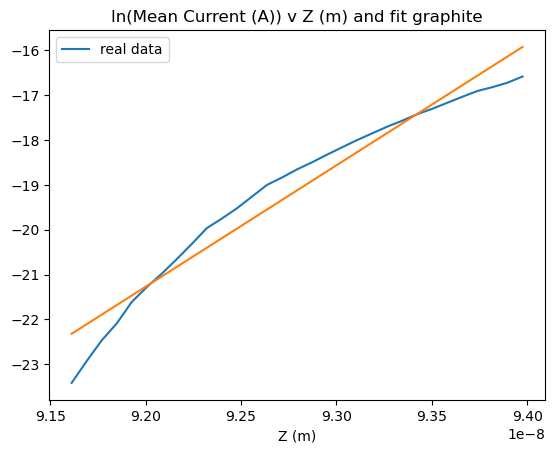

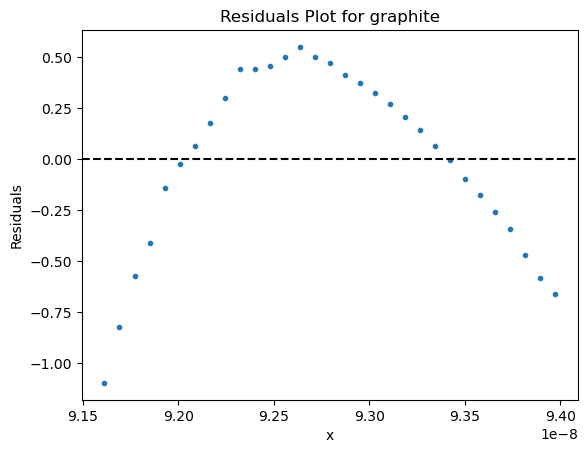

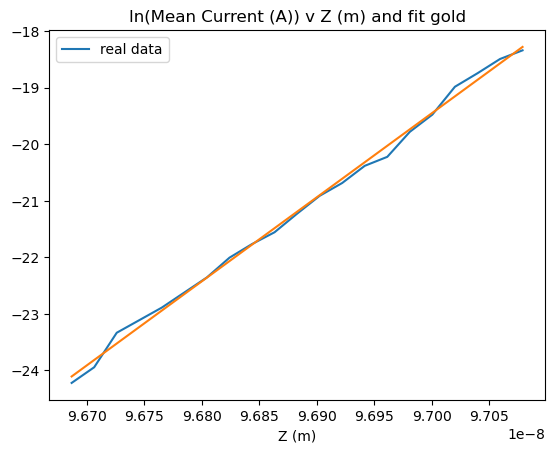

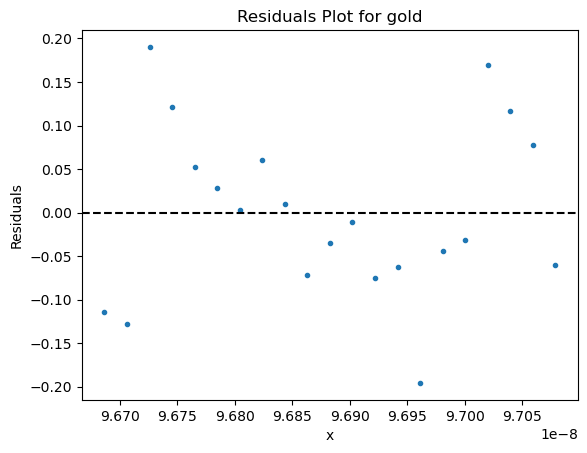

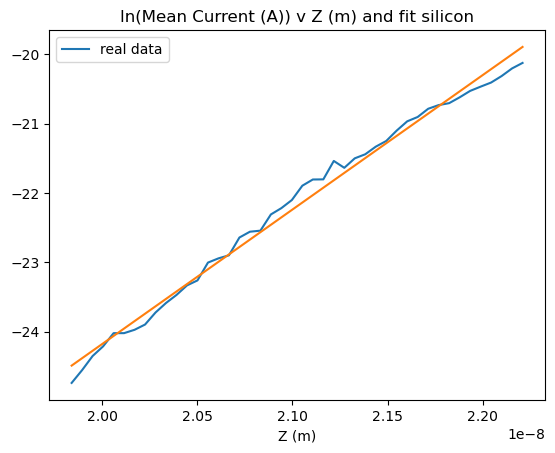

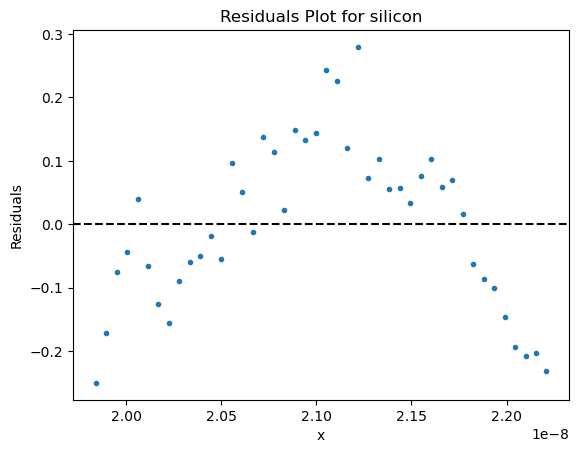

In [5]:
mean_dfs_trunc["gold"] = mean_dfs_trunc["gold"][:-10]
mean_dfs_trunc["silicon"] = mean_dfs_trunc["silicon"][34:-50]

for material in materials:
    model = linear_model.LinearRegression(fit_intercept=True)
    X = mean_dfs_trunc[material][["Z (m)"]]
    Y = mean_dfs_trunc[material]["ln(Mean Current (A))"]
    
    model.fit(X,Y)
    prediction = model.predict(X)
    print(f"Current Material: {material}")
    print("Line gradient from model: ", model.coef_)
    print("Line intercept from model:", model.intercept_, "\n")
    
    fig, ax = plt.subplots()
    mean_dfs_trunc[material].plot("Z (m)", "ln(Mean Current (A))", ax = ax, label = "real data")
    ax.plot(mean_dfs_trunc[material]["Z (m)"], prediction, label = "regression line")
    ax.set_title(f"ln(Mean Current (A)) v Z (m) and fit {material}")
    
    fig1, ax1  = plt.subplots()
    
    # Create a plot of residuals
    ax1.plot(mean_dfs_trunc[material]["Z (m)"], (Y - prediction),'.')
    
    # Add a horizontal line at zero to guide the eye
    ax1.axhline(0, color='k', linestyle='dashed')
    
    # Add axis labels
    ax1.set_title(f"Residuals Plot for {material}")
    ax1.set_xlabel("x")
    ax1.set_ylabel("Residuals")
    
    print(f"r2_score: {r2_score(Y,prediction)}")
    print(f"ROOT mean squared error: {root_mean_squared_error(Y,prediction)}", "\n")
    
    error_work_func = np.std((Y - prediction))
    print("Final Work Function (eV): ", str((model.coef_[0] / 1.0250E-10) * 1.6E-19), " \u00B1 ", error_work_func, " eV", "\n===========================\n")

## Summary of Work Functions Obtained compared to Literature Values

| Material | Literature Work Function ($eV$) |  Obtained Work Function ($eV$)
|-------|-----------|-----------|
| Graphite  | 2.9 - 5.0     | 4.23 $\pm$ 0.40     |
| Gold     | 5.3 - 5.5     | 23.0 $\pm$ 0.10     |
| Silicon     | 4.7 - 4.9     | 3.03 $\pm$ 0.10     |.

[2], [3], [4]

## References

[1] [Nanoscience of the Tip](https://depts.washington.edu/nanolab/NUE_UNIQUE/Background/AFM.pdf)

[2] [Work Function Lowering of Graphite by Sequential Surface Modifications: Nitrogen and Hydrogen Plasma Treatment ](https://pubs.acs.org/doi/10.1021/acsomega.9b02208)

[3] [The work function of gold](https://ui.adsabs.harvard.edu/abs/1966SurSc...5..221S/abstract#:~:text=For%20a%20fresh%20gold%20film,it%20increased%20to%205.38%20eV.)

[4] [Work Function, Photoelectric Threshold, and Surface States of Atomically Clean Silicon ](https://journals.aps.org/pr/abstract/10.1103/PhysRev.127.150#:~:text=The%20work%20function%20varies%20only,eV%20below%20the%20mid%2Dgap.)